# Mini-project3
Add noise to a dataset of your choice, then train an autoencoder to denoise it.

P.S: you can use the one you have chosen in the last assignment.



In [ ]:
%matplotlib inline
import keras
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
'''
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.models import Model'''
np.random.seed(1337)

## Dataset

4422102/4422102 [==============================] - 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


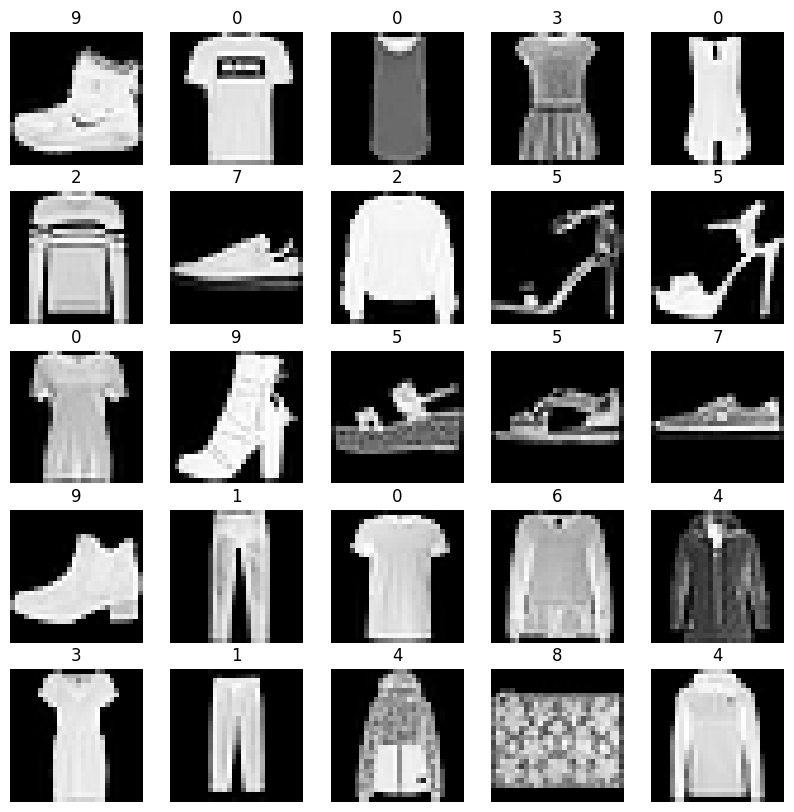

In [ ]:
# Load the Fashion-MNIST dataset
fashion_mnist = keras.datasets.fashion_mnist
# Split the dataset into training and testing sets
(x_train, train_labels), (x_test, test_labels) = fashion_mnist.load_data()
# summarize the shape of the dataset
print('Train', x_train.shape, train_labels.shape)
print('Test', x_test.shape, test_labels.shape)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i], cmap='Greys_r')
    plt.title(train_labels[i])
    plt.axis('off')
plt.show()

In [ ]:
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

## Normalize the data
x_train = x_train.astype('float32') / 255      
x_test = x_test.astype('float32') / 255

# summarize the shape of the dataset
print('Train', x_train.shape)
print('Test', x_test.shape)

Train (60000, 28, 28, 1)
Test (10000, 28, 28, 1)


In [ ]:
# Generate corrupted MNIST images by adding noise with normal dist
# centered at 0.5 and std=0.3
noise = np.random.normal(loc=0.5, scale=0.3, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.3, size=x_test.shape)
x_test_noisy = x_test + noise

# Clip the images to be between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

## Model

In [ ]:
#Encoder Model
input = Input(shape=(28, 28, 1), name='encoder_input')

x = Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
encoded = MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoded = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, decoded)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 32)       9248  

## Training our Autoencoder

In [ ]:
autoencoder.fit(x = x_train_noisy,
                y = x_train,
                validation_split = 0.2,
                # validation_date = (x_test, x_test_noisy),
                epochs=100,
                shuffle = True,
                batch_size=128)

Epoch 1/100
375/375 [==============================] - 14s 9ms/step - loss: 0.3621 - val_loss: 0.3115
Epoch 2/100
375/375 [==============================] - 3s 7ms/step - loss: 0.3057 - val_loss: 0.3032
Epoch 3/100
375/375 [==============================] - 3s 7ms/step - loss: 0.3002 - val_loss: 0.2992
Epoch 4/100
375/375 [==============================] - 3s 7ms/step - loss: 0.2967 - val_loss: 0.2962
Epoch 5/100
375/375 [==============================] - 3s 7ms/step - loss: 0.2943 - val_loss: 0.2945
Epoch 6/100
375/375 [==============================] - 3s 8ms/step - loss: 0.2925 - val_loss: 0.2928
Epoch 7/100
375/375 [==============================] - 3s 7ms/step - loss: 0.2910 - val_loss: 0.2913
Epoch 8/100
375/375 [==============================] - 3s 8ms/step - loss: 0.2900 - val_loss: 0.2909
Epoch 9/100
375/375 [==============================] - 3s 7ms/step - loss: 0.2888 - val_loss: 0.2894
Epoch 10/100
375/375 [==============================] - 3s 8ms/step - loss: 0.2878 - val_l

## Results

313/313 [==============================] - 1s 3ms/step


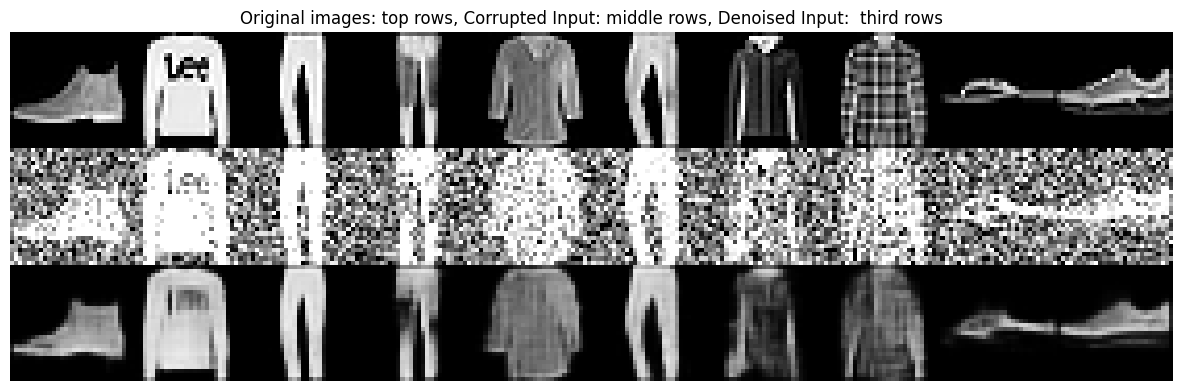

In [ ]:
# Predict the Autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

# Display the 1st 10 corrupted and denoised images
rows, cols = 1, 10
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
fig = plt.figure()
fig.set_figheight(7)
fig.set_figwidth(15)
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()